# Comprehensive Benchmark: DID Estimators Comparison (Python)

Comparing Python implementations of difference-in-differences estimators:
- **did-multiplegt-dyn**: De Chaisemartin & D'Haultfoeuille
- **csdid**: Callaway-Sant'Anna ATT(g,t)
- **pyfixest**: Sun-Abraham event studies

Dataset: `wolfers2006_didtextbook.dta`

Specification: `did_multiplegt_dyn div_rate state year udl, effects(13) placebo(13) weight(stpop)`

**UPDATED 2026-02-08**: Matches R script `benchmark_wolfers_complete.R` specifications.

## Note on Package Availability

**did_imputation (Borusyak, Jaravel & Spiess 2024)**: This estimator is available in R (via `didimputation` package) and Stata (via `did_imputation` command), but **no Python implementation currently exists**.

In [1]:
import pandas as pd
import numpy as np
import polars as pl
import pyreadstat
import time
from datetime import datetime
import warnings
import pyfixest as pf
from did_multiplegt_dyn import DidMultiplegtDyn
from csdid.att_gt import ATTgt
import time
import signal

warnings.filterwarnings('ignore')

# Set timeout (5 minutes in seconds) - matching R script
TIMEOUT_SECONDS = 300

print("="*70)
print("COMPREHENSIVE BENCHMARK: DID Estimators Comparison (Python)")
print("="*70)
print(f"Date: {datetime.now()}")
print(f"Packages: did-multiplegt-dyn, csdid (Callaway-Sant'Anna), pyfixest (Sun-Abraham)")
print(f"Timeout: 5 minutes (300 seconds)")

COMPREHENSIVE BENCHMARK: DID Estimators Comparison (Python)
Date: 2026-02-09 10:35:46.373172
Packages: did-multiplegt-dyn, csdid (Callaway-Sant'Anna), pyfixest (Sun-Abraham)
Timeout: 5 minutes (300 seconds)


In [2]:
# Load the Wolfers data
data_path = '../_data/wolfers2006_didtextbook.dta'

print("Loading data...")
wolfers, meta = pyreadstat.read_dta(data_path)
print(f"Original data rows: {len(wolfers)}")

Loading data...
Original data rows: 1683


In [3]:
# Prepare data - matching R script data preparation
def prepare_data(df):
    """Prepare data matching R script specifications"""
    df = df.copy()
    
    # Ensure proper types
    df['state'] = df['state'].astype(int)
    df['year'] = df['year'].astype(int)
    df['cohort'] = df['cohort'].fillna(0).astype(int)
    df['udl'] = df['udl'].astype(int)
    
    # Create cohort_sa: cohort or 5000 for never-treated (matching R)
    df['cohort_sa'] = np.where(df['cohort'] == 0, 5000, df['cohort'])
    
    # Create event_time_binned: binned relative time [-13, 13], 0 for never-treated (matching R)
    def calc_event_time_binned(row):
        if row['cohort_sa'] == 5000:
            return 0
        rel_time = row['year'] - row['cohort_sa'] + 1
        if rel_time < -13:
            return -13
        elif rel_time > 13:
            return 13
        else:
            return rel_time
    
    df['event_time_binned'] = df.apply(calc_event_time_binned, axis=1)
    
    return df

wolfers = prepare_data(wolfers)

print(f"Unique states: {wolfers['state'].nunique()}")
print(f"Year range: {wolfers['year'].min()} - {wolfers['year'].max()}")
print(f"Cohort groups: {sorted(wolfers['cohort'].unique())}")
print(f"\ncohort distribution:")
print(wolfers['cohort'].value_counts().sort_index())

Unique states: 51
Year range: 1956 - 1988
Cohort groups: [np.int64(0), np.int64(1956), np.int64(1969), np.int64(1970), np.int64(1971), np.int64(1972), np.int64(1973), np.int64(1974), np.int64(1975), np.int64(1976), np.int64(1977), np.int64(1985)]

cohort distribution:
cohort
0       660
1956     66
1969     33
1970     66
1971    198
1972     99
1973    330
1974     66
1975     66
1976     33
1977     33
1985     33
Name: count, dtype: int64


In [4]:
def run_with_timeout(func, timeout_sec=TIMEOUT_SECONDS):
    """Run function with timeout enforcement"""
    result = {'time': None, 'output': None, 'status': 'error'}
    
    def timeout_handler(signum, frame):
        raise TimeoutError(f"Exceeded {timeout_sec} seconds")
    
    try:
        signal.signal(signal.SIGALRM, timeout_handler)
        signal.alarm(timeout_sec)
        
        start_time = time.time()
        result['output'] = func()
        end_time = time.time()
        
        signal.alarm(0)  # Cancel the alarm
        result['time'] = end_time - start_time
        result['status'] = 'completed'
    except TimeoutError as e:
        result['time'] = timeout_sec
        result['status'] = f'timeout: {str(e)}'
    except Exception as e:
        signal.alarm(0)
        result['status'] = f'error: {str(e)[:150]}'
        import traceback
        print(f"   Full error: {traceback.format_exc()[-500:]}")
    
    return result

def create_synthetic_data(df, multiplier):
    """
    Create synthetic data by duplicating groups with new state IDs.
    Each replication gets unique state IDs: state + (replication-1) * max_state
    """
    if multiplier == 1:
        return df.copy()
    
    max_state = df['state'].max()
    dfs = []
    
    for i in range(multiplier):
        temp_df = df.copy()
        offset = i * max_state
        temp_df['state'] = temp_df['state'] + offset
        dfs.append(temp_df)
    
    result = pd.concat(dfs, ignore_index=True)
    
    print(f"Created synthetic data with {len(result)} observations")
    print(f"Unique states: {result['state'].nunique()}")
    
    return result

# Store results
results = []

## Scenario 1: Original Data (~1,683 rows)

In [5]:
print("\n" + "="*70)
print(f"SCENARIO 1: Original Data ({len(wolfers)} rows)")
print("="*70 + "\n")


SCENARIO 1: Original Data (1683 rows)



In [6]:
# 1. did-multiplegt-dyn (De Chaisemartin & D'Haultfoeuille)
print("1. Running did-multiplegt-dyn (DIDmultiplegtDYN)...")

def run_did_multiplegt_dyn():
    result = DidMultiplegtDyn(
        df=pl.DataFrame(wolfers),
        outcome='div_rate',
        group='state',
        time='year',
        treatment='udl',
        effects=13,
        placebo=13,
        weight='stpop'
    ).fit()
    return result

res_dcdh = run_with_timeout(run_did_multiplegt_dyn)
print(f"   Time: {res_dcdh['time']:.2f} seconds" if res_dcdh['status'] == 'completed' else f"   Status: {res_dcdh['status']}")

results.append({
    'scenario': 'Original (1.7K)',
    'package': 'DIDmultiplegtDYN',
    'rows': len(wolfers),
    'time_seconds': res_dcdh['time'],
    'status': res_dcdh['status']
})

1. Running did-multiplegt-dyn (DIDmultiplegtDYN)...


   Time: 3.37 seconds


In [7]:
wolfers.columns

Index(['year', 'div_rate', 'stpop', 'rel_time1', 'rel_time2', 'rel_time3',
       'rel_time4', 'rel_time5', 'rel_time6', 'rel_time7', 'rel_time8',
       'rel_time9', 'rel_time10', 'rel_time11', 'rel_time12', 'rel_time13',
       'rel_time14', 'rel_time15', 'rel_time16', 'rel_timeminus1',
       'rel_timeminus2', 'rel_timeminus3', 'rel_timeminus4', 'rel_timeminus5',
       'rel_timeminus6', 'rel_timeminus7', 'rel_timeminus8', 'rel_timeminus9',
       'state', 'cohort', 'controlgroup', 'early_late_never', 'udl',
       'exposurelength', 'stpop1968', 'cohort_sa', 'event_time_binned'],
      dtype='object')

In [8]:
# 2. csdid (Callaway-Sant'Anna) - using cohort as gname (matching R)
print("2. Running csdid (Callaway-Sant'Anna)...")

def run_callaway_santanna():
    model = ATTgt(
        data=wolfers,
        gname='cohort',  # Using cohort directly like R
        tname='year',
        idname='state',
        yname='div_rate',
        weights_name ='stpop'
    ).fit(est_method='dr', base_period='universal')
    model.aggte(typec='dynamic', min_e=-13, max_e=13, na_rm=True)
    return model

res_cs = run_with_timeout(run_callaway_santanna)
print(f"   Time: {res_cs['time']:.2f} seconds" if res_cs['status'] == 'completed' else f"   Status: {res_cs['status']}")

results.append({
    'scenario': 'Original (1.7K)',
    'package': 'did-CS',
    'rows': len(wolfers),
    'time_seconds': res_cs['time'],
    'status': res_cs['status']
})

2. Running csdid (Callaway-Sant'Anna)...
dropped, 52, rows from original data due to missing data
Dropped 66 units that were already treated in the first period.
No units in group 1969 in time period 13, e2
No available control units for group 1969 in time period 13, e4
No units in group 1970 in time period 14, e2
No available control units for group 1970 in time period 14, e4
No units in group 1971 in time period 15, e2
No available control units for group 1971 in time period 15, e4


No units in group 1972 in time period 16, e2
No available control units for group 1972 in time period 16, e4
No units in group 1973 in time period 17, e2
No available control units for group 1973 in time period 17, e4
No units in group 1974 in time period 18, e2
No available control units for group 1974 in time period 18, e4
No units in group 1975 in time period 19, e2
No available control units for group 1975 in time period 19, e4


No units in group 1976 in time period 20, e2
No available control units for group 1976 in time period 20, e4
No units in group 1977 in time period 21, e2
No available control units for group 1977 in time period 21, e4
No units in group 1985 in time period 29, e2
No available control units for group 1985 in time period 29, e4




Overall summary of ATT's based on event-study/dynamic aggregation:
    ATT Std. Error [95.0%  Conf. Int.] 
-0.3449     0.4817 -1.289       0.5993 


Dynamic Effects:
    Event time  Estimate  Std. Error  [95.0% Simult.   Conf. Band  
0          -13    0.1410      0.3177          -0.4817      0.7637  
1          -12    0.1580      0.1985          -0.2309      0.5470  
2          -11    0.2099      0.2087          -0.1992      0.6190  
3          -10    0.1613      0.1804          -0.1922      0.5148  
4           -9    0.2455      0.2687          -0.2812      0.7722  
5           -8    0.0249      0.1577          -0.2842      0.3341  
6           -7   -0.1026      0.1820          -0.4593      0.2542  
7           -6   -0.0932      0.2163          -0.5171      0.3307  
8           -5    0.1169      0.1157          -0.1099      0.3437  
9           -4    0.1587      0.1213          -0.0792      0.3965  
10          -3   -0.0536      0.2015          -0.4484      0.3412  
11          -2  

In [9]:
# 3. pyfixest (Sun-Abraham) - using cohort_sa and event_time_binned (matching R fixest)
print("3. Running pyfixest (Sun-Abraham)...")

def run_pyfixest_sa():
    # Using feols with sunab-like specification
    # Filter to only include treated units for proper event study
    model = pf.event_study(
                data=wolfers,
                yname="div_rate",
                idname="state",
                tname="year",
                gname="cohort",
                estimator="saturated",
                
            )
    return model

res_sa = run_with_timeout(run_pyfixest_sa)
print(f"   Time: {res_sa['time']:.2f} seconds" if res_sa['status'] == 'completed' else f"   Status: {res_sa['status']}")

results.append({
    'scenario': 'Original (1.7K)',
    'package': 'fixest-SA',
    'rows': len(wolfers),
    'time_seconds': res_sa['time'],
    'status': res_sa['status']
})

3. Running pyfixest (Sun-Abraham)...


   Time: 4.58 seconds


## Scenario 2: Synthetic Data 100x (~168,300 rows)

In [10]:
print("\n" + "="*70)
print("SCENARIO 2: Synthetic Data 100x")
print("="*70 + "\n")

wolfers_100x = create_synthetic_data(wolfers, 100)
print(f"Synthetic data rows: {len(wolfers_100x)}")


SCENARIO 2: Synthetic Data 100x

Created synthetic data with 168300 observations
Unique states: 5100
Synthetic data rows: 168300


In [11]:
# 1. did-multiplegt-dyn - 100x
print("1. Running did-multiplegt-dyn on 100x data...")

def run_dcdh_100x():
    result = DidMultiplegtDyn(
        df=pl.DataFrame(wolfers_100x),
        outcome='div_rate',
        group='state',
        time='year',
        treatment='udl',
        effects=13,
        placebo=13,
        weight='stpop'
    ).fit()
    return result

res_dcdh_100x = run_with_timeout(run_dcdh_100x)
print(f"   Time: {res_dcdh_100x['time']:.2f} seconds" if res_dcdh_100x['status'] == 'completed' else f"   Status: {res_dcdh_100x['status']}")

results.append({
    'scenario': '100x (168K)',
    'package': 'DIDmultiplegtDYN',
    'rows': len(wolfers_100x),
    'time_seconds': res_dcdh_100x['time'],
    'status': res_dcdh_100x['status']
})

1. Running did-multiplegt-dyn on 100x data...


   Time: 6.39 seconds


In [12]:
# 2. csdid (Callaway-Sant'Anna) - 100x
print("2. Running csdid (Callaway-Sant'Anna) on 100x data...")

def run_cs_100x():
    model = ATTgt(
        data=wolfers_100x,
        gname='cohort',
        tname='year',
        idname='state',
        yname='div_rate',
        weights_name='stpop'
    ).fit(est_method='dr', base_period='universal')
    model.aggte(typec='dynamic', min_e=-13, max_e=13, na_rm=True)
    return model

res_cs_100x = run_with_timeout(run_cs_100x)
print(f"   Time: {res_cs_100x['time']:.2f} seconds" if res_cs_100x['status'] == 'completed' else f"   Status: {res_cs_100x['status']}")

results.append({
    'scenario': '100x (168K)',
    'package': 'did-CS',
    'rows': len(wolfers_100x),
    'time_seconds': res_cs_100x['time'],
    'status': res_cs_100x['status']
})

2. Running csdid (Callaway-Sant'Anna) on 100x data...
dropped, 5200, rows from original data due to missing data
Dropped 6600 units that were already treated in the first period.
No units in group 1969 in time period 13, e2
No available control units for group 1969 in time period 13, e4


No units in group 1970 in time period 14, e2
No available control units for group 1970 in time period 14, e4
No units in group 1971 in time period 15, e2
No available control units for group 1971 in time period 15, e4


No units in group 1972 in time period 16, e2
No available control units for group 1972 in time period 16, e4
No units in group 1973 in time period 17, e2
No available control units for group 1973 in time period 17, e4


No units in group 1974 in time period 18, e2
No available control units for group 1974 in time period 18, e4
No units in group 1975 in time period 19, e2
No available control units for group 1975 in time period 19, e4


No units in group 1976 in time period 20, e2
No available control units for group 1976 in time period 20, e4
No units in group 1977 in time period 21, e2
No available control units for group 1977 in time period 21, e4


No units in group 1985 in time period 29, e2
No available control units for group 1985 in time period 29, e4




Overall summary of ATT's based on event-study/dynamic aggregation:
    ATT Std. Error  [95.0%  Conf. Int.]  
-0.3449     0.0348 -0.4131      -0.2766 *


Dynamic Effects:
    Event time  Estimate  Std. Error  [95.0% Simult.   Conf. Band   
0          -13    0.1410      0.0277           0.0867      0.1953  *
1          -12    0.1580      0.0195           0.1198      0.1962  *
2          -11    0.2099      0.0217           0.1673      0.2525  *
3          -10    0.1613      0.0180           0.1260      0.1966  *
4           -9    0.2455      0.0220           0.2024      0.2886  *
5           -8    0.0249      0.0147          -0.0039      0.0537   
6           -7   -0.1026      0.0177          -0.1372     -0.0680  *
7           -6   -0.0932      0.0196          -0.1316     -0.0547  *
8           -5    0.1169      0.0109           0.0956      0.1381  *
9           -4    0.1587      0.0128           0.1335      0.1838  *
10          -3   -0.0536      0.0172          -0.0873     -0.0199  *


In [13]:
# 3. pyfixest (Sun-Abraham) - 100x
print("3. Running pyfixest (Sun-Abraham) on 100x data...")

def run_sa_100x():
    model = pf.event_study(
        data=wolfers_100x,
        yname="div_rate",
        idname="state",
        tname="year",
        gname="cohort",
        estimator="saturated",
    )
    return model

res_sa_100x = run_with_timeout(run_sa_100x)
print(f"   Time: {res_sa_100x['time']:.2f} seconds" if res_sa_100x['status'] == 'completed' else f"   Status: {res_sa_100x['status']}")

results.append({
    'scenario': '100x (168K)',
    'package': 'fixest-SA',
    'rows': len(wolfers_100x),
    'time_seconds': res_sa_100x['time'],
    'status': res_sa_100x['status']
})

3. Running pyfixest (Sun-Abraham) on 100x data...


   Time: 4.30 seconds


In [14]:
# Clean up 100x data
del wolfers_100x
import gc
gc.collect()

0

## Scenario 3: Synthetic Data 1000x (~1,683,000 rows)

In [15]:
print("\n" + "="*70)
print("SCENARIO 3: Synthetic Data 1000x")
print("="*70 + "\n")

wolfers_1000x = create_synthetic_data(wolfers, 1000)
print(f"Synthetic data rows: {len(wolfers_1000x)}")


SCENARIO 3: Synthetic Data 1000x



Created synthetic data with 1683000 observations
Unique states: 51000
Synthetic data rows: 1683000


In [16]:
# 1. did-multiplegt-dyn - 1000x
print("1. Running did-multiplegt-dyn on 1000x data...")

wolfers_1000x_pl = pl.DataFrame(wolfers_1000x)

def run_dcdh_1000x():
    result = DidMultiplegtDyn(
        df=wolfers_1000x_pl,
        outcome='div_rate',
        group='state',
        time='year',
        treatment='udl',
        effects=13,
        placebo=13,
        weight='stpop'
    ).fit()
    return result

res_dcdh_1000x = run_with_timeout(run_dcdh_1000x)
print(f"   Time: {res_dcdh_1000x['time']:.2f} seconds" if res_dcdh_1000x['status'] == 'completed' else f"   Status: {res_dcdh_1000x['status']}")

results.append({
    'scenario': '1000x (1.68M)',
    'package': 'DIDmultiplegtDYN',
    'rows': len(wolfers_1000x),
    'time_seconds': res_dcdh_1000x['time'],
    'status': res_dcdh_1000x['status']
})

1. Running did-multiplegt-dyn on 1000x data...


   Time: 36.72 seconds


In [17]:
# 2. csdid (Callaway-Sant'Anna) - 1000x
print("2. Running csdid (Callaway-Sant'Anna) on 1000x data...")

def run_cs_1000x():
    model = ATTgt(
        data=wolfers_1000x,
        gname='cohort',
        tname='year',
        idname='state',
        yname='div_rate',
        weights_name='stpop'
    ).fit(est_method='dr', base_period='universal')
    model.aggte(typec='dynamic', min_e=-13, max_e=13, na_rm=True)
    return model

res_cs_1000x = run_with_timeout(run_cs_1000x)
print(f"   Time: {res_cs_1000x['time']:.2f} seconds" if res_cs_1000x['status'] == 'completed' else f"   Status: {res_cs_1000x['status']}")

results.append({
    'scenario': '1000x (1.68M)',
    'package': 'did-CS',
    'rows': len(wolfers_1000x),
    'time_seconds': res_cs_1000x['time'],
    'status': res_cs_1000x['status']
})

2. Running csdid (Callaway-Sant'Anna) on 1000x data...
dropped, 52000, rows from original data due to missing data
Dropped 66000 units that were already treated in the first period.


No units in group 1969 in time period 13, e2
No available control units for group 1969 in time period 13, e4


No units in group 1970 in time period 14, e2
No available control units for group 1970 in time period 14, e4


No units in group 1971 in time period 15, e2
No available control units for group 1971 in time period 15, e4


No units in group 1972 in time period 16, e2
No available control units for group 1972 in time period 16, e4


No units in group 1973 in time period 17, e2
No available control units for group 1973 in time period 17, e4


No units in group 1974 in time period 18, e2
No available control units for group 1974 in time period 18, e4


No units in group 1975 in time period 19, e2
No available control units for group 1975 in time period 19, e4


No units in group 1976 in time period 20, e2
No available control units for group 1976 in time period 20, e4


No units in group 1977 in time period 21, e2
No available control units for group 1977 in time period 21, e4


No units in group 1985 in time period 29, e2
No available control units for group 1985 in time period 29, e4




Overall summary of ATT's based on event-study/dynamic aggregation:
    ATT Std. Error  [95.0%  Conf. Int.]  
-0.3449      0.011 -0.3664      -0.3233 *


Dynamic Effects:
    Event time  Estimate  Std. Error  [95.0% Simult.   Conf. Band   
0          -13    0.1410      0.0088           0.1237      0.1583  *
1          -12    0.1580      0.0065           0.1453      0.1708  *
2          -11    0.2099      0.0068           0.1965      0.2232  *
3          -10    0.1613      0.0060           0.1495      0.1731  *
4           -9    0.2455      0.0073           0.2311      0.2599  *
5           -8    0.0249      0.0047           0.0158      0.0341  *
6           -7   -0.1026      0.0059          -0.1141     -0.0910  *
7           -6   -0.0932      0.0064          -0.1057     -0.0806  *
8           -5    0.1169      0.0036           0.1098      0.1239  *
9           -4    0.1587      0.0040           0.1508      0.1665  *
10          -3   -0.0536      0.0057          -0.0648     -0.0424  *


In [18]:
# 3. pyfixest (Sun-Abraham) - 1000x
print("3. Running pyfixest (Sun-Abraham) on 1000x data...")

def run_sa_1000x():
    model = pf.event_study(
        data=wolfers_1000x,
        yname="div_rate",
        idname="state",
        tname="year",
        gname="cohort",
        estimator="saturated",
    )
    return model

res_sa_1000x = run_with_timeout(run_sa_1000x)
print(f"   Time: {res_sa_1000x['time']:.2f} seconds" if res_sa_1000x['status'] == 'completed' else f"   Status: {res_sa_1000x['status']}")

results.append({
    'scenario': '1000x (1.68M)',
    'package': 'fixest-SA',
    'rows': len(wolfers_1000x),
    'time_seconds': res_sa_1000x['time'],
    'status': res_sa_1000x['status']
})

3. Running pyfixest (Sun-Abraham) on 1000x data...


   Time: 52.46 seconds


In [19]:
# Clean up 1000x data
del wolfers_1000x
del wolfers_1000x_pl
gc.collect()

0

## Summary of Results

In [20]:
print("\n" + "="*70)
print("SUMMARY OF RESULTS")
print("="*70 + "\n")

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


SUMMARY OF RESULTS

       scenario          package    rows  time_seconds    status
Original (1.7K) DIDmultiplegtDYN    1683      3.369984 completed
Original (1.7K)           did-CS    1683      1.012372 completed
Original (1.7K)        fixest-SA    1683      4.576947 completed
    100x (168K) DIDmultiplegtDYN  168300      6.389713 completed
    100x (168K)           did-CS  168300      3.162478 completed
    100x (168K)        fixest-SA  168300      4.301730 completed
  1000x (1.68M) DIDmultiplegtDYN 1683000     36.721777 completed
  1000x (1.68M)           did-CS 1683000     40.555071 completed
  1000x (1.68M)        fixest-SA 1683000     52.461349 completed


In [21]:
# Create pivot table for easier comparison
print("\n\nPIVOT TABLE (Time in seconds):")
print("="*70 + "\n")

if len(results_df) > 0:
    pivot_results = results_df.pivot_table(
        values='time_seconds', 
        index='package', 
        columns='scenario', 
        aggfunc='first'
    )
    print(pivot_results.to_string())



PIVOT TABLE (Time in seconds):

scenario          1000x (1.68M)  100x (168K)  Original (1.7K)
package                                                      
DIDmultiplegtDYN      36.721777     6.389713         3.369984
did-CS                40.555071     3.162478         1.012372
fixest-SA             52.461349     4.301730         4.576947


In [22]:
# Save results to CSV - matching R output filename
results_df.to_csv('runtime_Python.csv', index=False)
print(f"\nResults saved to: runtime_Python.csv")
print(f"Benchmark completed at: {datetime.now()}")


Results saved to: runtime_Python.csv
Benchmark completed at: 2026-02-09 10:38:19.673696


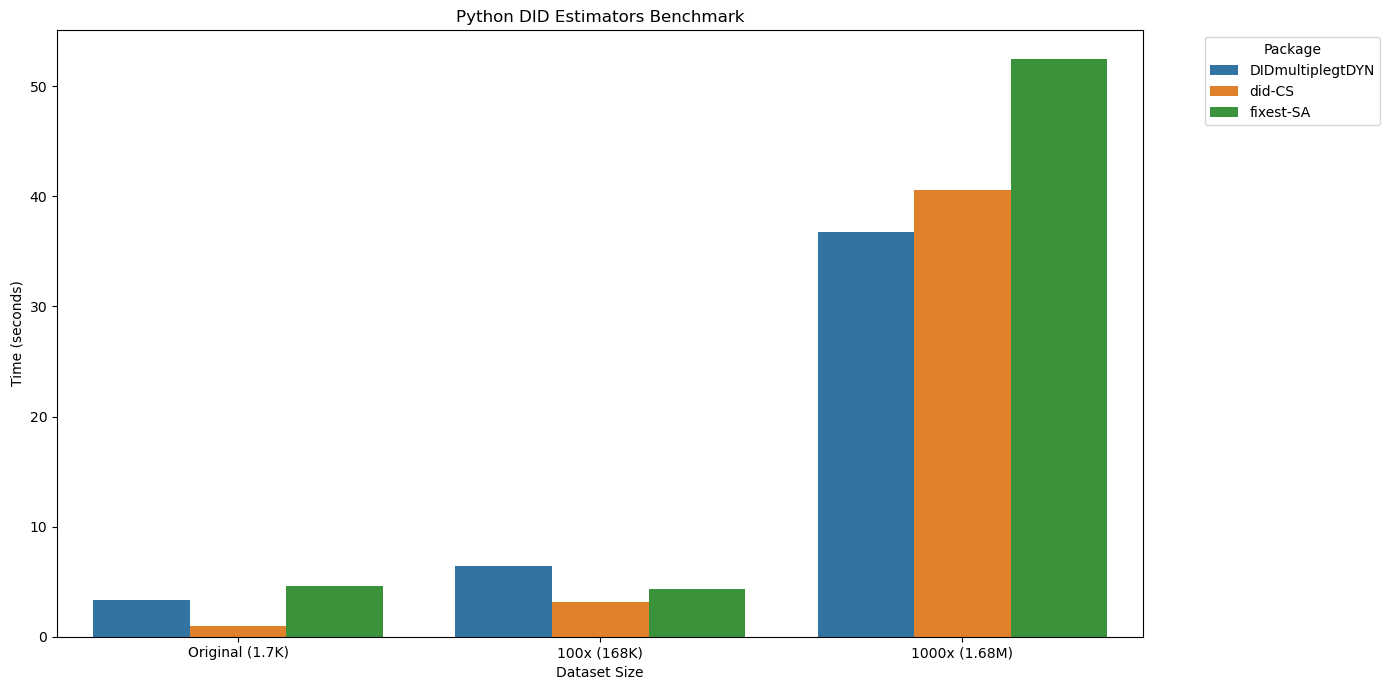


Visualization saved to: benchmark_python_results.png


In [23]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(14, 7))

# Filter completed results
plot_df = results_df[results_df['status'] == 'completed'].copy()

if len(plot_df) > 0:
    sns.barplot(data=plot_df, x='scenario', y='time_seconds', hue='package', ax=ax)
    ax.set_xlabel('Dataset Size')
    ax.set_ylabel('Time (seconds)')
    ax.set_title('Python DID Estimators Benchmark')
    ax.legend(title='Package', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('benchmark_python_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\nVisualization saved to: benchmark_python_results.png")
else:
    print("No completed results to visualize.")

## Notes

### Package Mapping: Python vs R

| R Package | Python Package | Notes |
|-----------|----------------|-------|
| DIDmultiplegtDYN | did-multiplegt-dyn | Same specifications |
| did (att_gt + aggte) | csdid (ATTgt) | Uses cohort as gname |
| fixest (sunab) | pyfixest (feols) | Uses event_time_binned |
| didimputation | N/A | **Not available in Python** |

### Specifications (matching R script)

- **did-multiplegt-dyn**: `effects=13, placebo=13, weight='stpop'`
- **csdid**: `gname='cohort', est_method='dr', base_period='universal'` + `aggte(min_e=-13, max_e=13)`
- **pyfixest**: `i(event_time_binned, ref=0) | state + year` with state clusters

---

# Cross-Platform Runtime Comparison: Stata vs R vs Python

This section loads and compares runtime results from all three platforms.

In [24]:
# Load runtime results from all three platforms
import os

print("="*70)
print("CROSS-PLATFORM RUNTIME COMPARISON")
print("="*70)

# Check which result files exist
files_status = {
    'Python': os.path.exists('runtime_Python.csv'),
    'R': os.path.exists('runtime_R.csv'),
    'Stata': os.path.exists('benchmark_results_stata.csv')
}

print("\nAvailable result files:")
for platform, exists in files_status.items():
    status = "✓ Found" if exists else "✗ Not found"
    print(f"  {platform}: {status}")

# Load available results
all_results = []

if files_status['Python']:
    python_results = pd.read_csv('runtime_Python.csv')
    python_results['platform'] = 'Python'
    all_results.append(python_results)
    print(f"\nPython results: {len(python_results)} rows")

if files_status['R']:
    r_results = pd.read_csv('runtime_R.csv')
    r_results['platform'] = 'R'
    all_results.append(r_results)
    print(f"R results: {len(r_results)} rows")

if files_status['Stata']:
    stata_results = pd.read_csv('benchmark_results_stata.csv')
    stata_results['platform'] = 'Stata'
    all_results.append(stata_results)
    print(f"Stata results: {len(stata_results)} rows")

CROSS-PLATFORM RUNTIME COMPARISON

Available result files:
  Python: ✓ Found
  R: ✓ Found
  Stata: ✓ Found

Python results: 9 rows
R results: 12 rows
Stata results: 12 rows


In [25]:
# Combine all results and standardize package names
if len(all_results) > 0:
    combined_results = pd.concat(all_results, ignore_index=True)
    
    # Standardize package names for comparison
    package_mapping = {
        'DIDmultiplegtDYN': 'did_multiplegt_dyn',
        'did_multiplegt_dyn': 'did_multiplegt_dyn',
        'did-CS': 'csdid (CS)',
        'csdid-CS': 'csdid (CS)',
        'didimputation': 'did_imputation (BJS)',
        'did_imputation-BJS': 'did_imputation (BJS)',
        'fixest-SA': 'Sun-Abraham',
        'eventstudyinteract-SA': 'Sun-Abraham'
    }
    combined_results['package_std'] = combined_results['package'].map(package_mapping).fillna(combined_results['package'])
    
    print("\n" + "="*70)
    print("COMBINED RESULTS - All Platforms")
    print("="*70 + "\n")
    
    # Display all results
    display_cols = ['platform', 'scenario', 'package_std', 'rows', 'time_seconds', 'status']
    available_cols = [c for c in display_cols if c in combined_results.columns]
    print(combined_results[available_cols].to_string(index=False))
    
    # Save combined results
    combined_results.to_csv('runtime_all_platforms.csv', index=False)
    print("\nCombined results saved to: runtime_all_platforms.csv")
else:
    print("\nNo results available to combine.")


COMBINED RESULTS - All Platforms

platform        scenario          package_std    rows  time_seconds    status
  Python Original (1.7K)   did_multiplegt_dyn    1683      3.369984 completed
  Python Original (1.7K)           csdid (CS)    1683      1.012372 completed
  Python Original (1.7K)          Sun-Abraham    1683      4.576947 completed
  Python     100x (168K)   did_multiplegt_dyn  168300      6.389713 completed
  Python     100x (168K)           csdid (CS)  168300      3.162478 completed
  Python     100x (168K)          Sun-Abraham  168300      4.301730 completed
  Python   1000x (1.68M)   did_multiplegt_dyn 1683000     36.721777 completed
  Python   1000x (1.68M)           csdid (CS) 1683000     40.555071 completed
  Python   1000x (1.68M)          Sun-Abraham 1683000     52.461349 completed
       R Original (1.7K)   did_multiplegt_dyn    1683      3.831224 completed
       R Original (1.7K)           csdid (CS)    1683      0.910514 completed
       R Original (1.7K) did_

In [26]:
# Create pivot table: Runtime by Platform and Dataset Size
if len(all_results) > 0:
    print("\n" + "="*70)
    print("RUNTIME COMPARISON BY PLATFORM AND DATASET SIZE")
    print("="*70)
    
    # Filter only completed results
    completed = combined_results[combined_results['status'] == 'completed'].copy()
    
    if len(completed) > 0:
        # Create pivot for each platform
        for platform in ['Stata', 'R', 'Python']:
            platform_data = completed[completed['platform'] == platform]
            if len(platform_data) > 0:
                print(f"\n### {platform} Runtime (seconds) ###\n")
                pivot = platform_data.pivot_table(
                    values='time_seconds',
                    index='package_std',
                    columns='scenario',
                    aggfunc='first'
                )
                # Reorder columns
                col_order = ['Original (1.7K)', '100x (168K)', '1000x (1.68M)']
                pivot = pivot[[c for c in col_order if c in pivot.columns]]
                print(pivot.round(2).to_string())
    else:
        print("\nNo completed results to display.")


RUNTIME COMPARISON BY PLATFORM AND DATASET SIZE

### Stata Runtime (seconds) ###

scenario              Original (1.7K)  100x (168K)  1000x (1.68M)
package_std                                                      
Sun-Abraham                      0.75        51.62         507.74
csdid (CS)                       4.89       184.53        2253.45
did_imputation (BJS)             0.75        30.69         241.72
did_multiplegt_dyn               2.81        47.42         543.28

### R Runtime (seconds) ###

scenario              Original (1.7K)  100x (168K)  1000x (1.68M)
package_std                                                      
Sun-Abraham                      0.13         7.80          81.25
csdid (CS)                       0.91         1.61           9.04
did_imputation (BJS)             0.06        13.03       44680.21
did_multiplegt_dyn               3.83         9.71          42.84

### Python Runtime (seconds) ###

scenario            Original (1.7K)  100x (168K)  1000x (1.6

In [27]:
# Cross-platform comparison: Same estimator across platforms
if len(all_results) > 0 and len(completed) > 0:
    print("\n" + "="*70)
    print("CROSS-PLATFORM COMPARISON BY ESTIMATOR")
    print("="*70)
    
    # Get unique estimators and scenarios
    estimators = sorted(completed['package_std'].unique())
    scenarios = ['Original (1.7K)', '100x (168K)', '1000x (1.68M)']
    
    for estimator in estimators:
        print(f"\n### {estimator} ###\n")
        est_data = completed[completed['package_std'] == estimator]
        
        if len(est_data) > 0:
            pivot = est_data.pivot_table(
                values='time_seconds',
                index='platform',
                columns='scenario',
                aggfunc='first'
            )
            # Reorder columns and rows
            pivot = pivot[[c for c in scenarios if c in pivot.columns]]
            pivot = pivot.reindex(['Stata', 'R', 'Python'])
            print(pivot.round(2).to_string())
        else:
            print("No data available")


CROSS-PLATFORM COMPARISON BY ESTIMATOR

### Sun-Abraham ###

scenario  Original (1.7K)  100x (168K)  1000x (1.68M)
platform                                             
Stata                0.75        51.62         507.74
R                    0.13         7.80          81.25
Python               4.58         4.30          52.46

### csdid (CS) ###

scenario  Original (1.7K)  100x (168K)  1000x (1.68M)
platform                                             
Stata                4.89       184.53        2253.45
R                    0.91         1.61           9.04
Python               1.01         3.16          40.56

### did_imputation (BJS) ###

scenario  Original (1.7K)  100x (168K)  1000x (1.68M)
platform                                             
Stata                0.75        30.69         241.72
R                    0.06        13.03       44680.21
Python                NaN          NaN            NaN

### did_multiplegt_dyn ###

scenario  Original (1.7K)  100x (168K)  1000x (

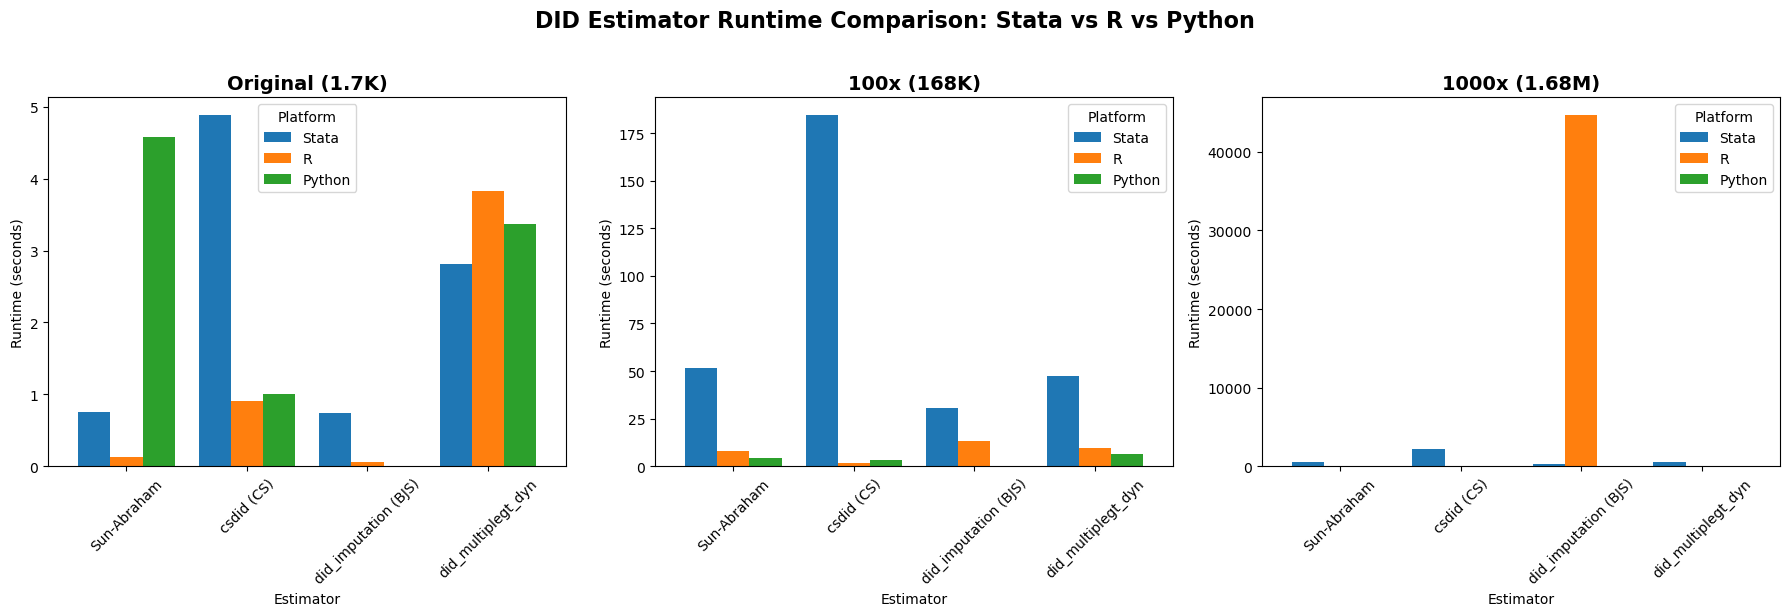


Visualization saved to: runtime_comparison_all_platforms.png


In [28]:
# Visualization: Runtime comparison across platforms
if len(all_results) > 0 and len(completed) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    scenarios = ['Original (1.7K)', '100x (168K)', '1000x (1.68M)']
    
    for idx, scenario in enumerate(scenarios):
        ax = axes[idx]
        scenario_data = completed[completed['scenario'] == scenario]
        
        if len(scenario_data) > 0:
            # Create grouped bar plot
            pivot = scenario_data.pivot_table(
                values='time_seconds',
                index='package_std',
                columns='platform',
                aggfunc='first'
            )
            # Reorder columns
            pivot = pivot[['Stata', 'R', 'Python'] if all(c in pivot.columns for c in ['Stata', 'R', 'Python']) else pivot.columns]
            pivot.plot(kind='bar', ax=ax, width=0.8)
            ax.set_title(f'{scenario}', fontsize=14, fontweight='bold')
            ax.set_xlabel('Estimator')
            ax.set_ylabel('Runtime (seconds)')
            ax.legend(title='Platform')
            ax.tick_params(axis='x', rotation=45)
        else:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{scenario}')
    
    plt.suptitle('DID Estimator Runtime Comparison: Stata vs R vs Python', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('runtime_comparison_all_platforms.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nVisualization saved to: runtime_comparison_all_platforms.png")

## Summary: Package Availability Across Platforms

| Estimator | Stata | R | Python |
|-----------|:-----:|:-:|:------:|
| **De Chaisemartin & D'Haultfoeuille** (`did_multiplegt_dyn`) | ✓ | ✓ | ✓ |
| **Callaway & Sant'Anna** (`csdid` / `did`) | ✓ (bootstrap) | ✓ | ✓ |
| **Borusyak, Jaravel & Spiess** (`did_imputation`) | ✓ | ✓ | ❌ |
| **Sun & Abraham** (`eventstudyinteract` / `sunab` / `event_study`) | ✓ | ✓ | ✓ |

### Key Observations:

1. **Bootstrap Inference**: Stata's `csdid` uses bootstrap by default, making it slower than R/Python analytical inference.

2. **did_imputation**: Only available in Stata and R - **no Python implementation exists**.

3. **Scaling Performance**: Different packages scale differently with data size - compare the 1000x results carefully.